In [1]:
import pickle
import numpy as np
import pomegranate as pom
import sys
sys.path.append('../src')
from visualization import draw_timeline_with_states, save_png, draw_distribution

from variables import toys_dict, tasks, toys_list
import matplotlib.pyplot as plt

from sklearn.preprocessing import KBinsDiscretizer
from sklearn.utils import check_random_state

import plotly.graph_objects as go
import plotly.express as px
import plotly.figure_factory as ff
import pandas as pd

from pathlib import Path
import os 
import importlib
from collections import OrderedDict

13


In [2]:
def create_independent_dist(feature, seed):
    unique_val = np.unique(feature)
    init_dict = {}
    random_state = check_random_state(seed)
    init_prob = random_state.rand(len(unique_val),1)
    init_prob = init_prob/init_prob.sum()
    
    for idx, i in enumerate(unique_val):
        init_dict[int(i)] = init_prob[idx].item()
    return pom.DiscreteDistribution(init_dict)

def create_dist_for_states(n_states, feature_list, seed):
    distributions = []
    i = 0
    for _ in range(n_states):
        dist_list = []
        for f in feature_list:
            dist = create_independent_dist(f, i)
            i += 1
            dist_list.append(dist)
        distributions.append(pom.IndependentComponentsDistribution(dist_list))
    return distributions

def init_hmm(n_components, feature_list, seed):
    random_state_trans = check_random_state(seed**seed)
    transitions = random_state_trans.rand(n_components, n_components)
    transitions = transitions/transitions.sum()
    
    random_state_start = check_random_state(seed**2)
    starts = random_state_start.rand(n_components)
    starts = starts/starts.sum()
    distributions = create_dist_for_states(n_components, feature_list, seed)
    model = pom.HiddenMarkovModel.from_matrix(transitions, distributions, starts)   
    return model
    

In [4]:
def discritize_with_sub(feature, threshold = 4):
    """
    Cap out the values at the higher end. Used for 'n_toys' and 'n_new_toys' features
    """
    return np.where(feature > threshold, threshold, feature)

def discritize_with_bins(feature, bins_):
    """
    Group values into different bins. Used for 'n_toy_switches" and 'fav_toy_ratio'
    """
    return np.digitize(feature, bins_, right = False)

def discritize_toy_iou(feature, discretizer):
    return iou_discretizer.transform(feature).reshape((-1,))

In [35]:
n_features = 4
feature_names = ["# toys switches", "# toys", "# new toys", 'fav toy ratio']

In [6]:
def convert_to_int(list_to_convert):
    converted_list = []
    for i in list_to_convert:
        i = i.astype(int)
        converted_list.append(i)
    return converted_list

def convert_to_list_seqs(big_seq, len_array):
    big_seq_to_slice = big_seq.copy()
    list_of_seqs = []
    
    for k in len_array:
        list_of_seqs.append(big_seq_to_slice[:k])
        big_seq_to_slice = big_seq_to_slice[k:]
    return list_of_seqs

def save_csv(df, file_path, file_name):
    if not os.path.exists(file_path):
        file_path.mkdir(parents=True)
    save_path = file_path / file_name
    df.to_csv(save_path)

In [7]:
with open('../data/interim/20210701_feature_engineering_1.5_min.pickle', 'rb') as f:
    feature_dict = pickle.load(f)

with open('../data/interim/20210701_label_1.5_min.pickle', 'rb') as f:
    labels_dict = pickle.load(f)

In [9]:
# task_specific_feature = feature_dict['MPS']
interval_length = 1.5  # every 2 minutes
no_ops_threshold = 5/60
new_toy_threshold = 2

shift_time_list = np.arange(0, interval_length, .5)

len_dict = {}
input_dict_by_task = {}
label_dict = {}

for task in tasks:
    input_dict_by_task[task] = np.empty((0, n_features))
    len_dict[task] = []
    label_dict[task] = []
    for subj, shifted_df_dict in feature_dict[task].items():
        for shift_time, feature_vector in shifted_df_dict.items():
            input_dict_by_task[task] = np.vstack((input_dict_by_task[task], feature_vector))
            label_dict[task].append(labels_dict[task][subj][shift_time])
            len_dict[task].append(len(feature_vector))

In [10]:
discretized_input_dict = {}
for task in tasks:
    discretized_input_dict[task] = input_dict_by_task[task].copy()
    discretized_input_dict[task][:,0] = discritize_with_bins(input_dict_by_task[task][:,0], bins_ = [0,10,20,30]) 
    discretized_input_dict[task][:,1] = discritize_with_sub(input_dict_by_task[task][:,1]) 
    discretized_input_dict[task][:,2] = discritize_with_sub(input_dict_by_task[task][:,2]) 
    discretized_input_dict[task][:,3] = discritize_with_bins(input_dict_by_task[task][:,3], bins_ =  [0, .2, .4, .6, .8]) 

In [11]:
sum_ = 0
for task in tasks:
    sum_ += np.sum(len_dict[task])
sum_

2506

### MPS

In [107]:
n_states_mps = 5
seed = 1

In [108]:
task = 'MPS' 
list_seq_mps = convert_to_list_seqs(discretized_input_dict[task], len_dict[task])
list_seq_mps = convert_to_int(list_seq_mps)
mps_model = init_hmm(n_states_mps, discretized_input_dict[task].T, seed)
mps_model.bake()
mps_model.fit(list_seq_mps, labels = label_dict[task])

                             "2" : 0.5615881112993137,
                                    "3" : 0.061771484926333525,
                                    "4" : 0.0
                                }
                            ],
                            "frozen" : false
                        },
                        {
                            "class" : "Distribution",
                            "dtype" : "int",
                            "name" : "DiscreteDistribution",
                            "parameters" : [
                                {
                                    "0" : 0.0,
                                    "1" : 0.0,
                                    "2" : 0.0,
                                    "3" : 0.6623702482484577,
                                    "4" : 0.3376297517515421
                                }
                            ],
                            "frozen" : false
                        },
                        {
      

In [111]:
label_dict[task]

[array([None, None, None, None, None, None], dtype=object),
 array([None, None, None, None, None], dtype=object),
 array([None, None, None, None, None], dtype=object),
 array([None, None, None, None, None, None], dtype=object),
 array([None, None, None, None, None], dtype=object),
 array([None, None, None, None, None], dtype=object),
 array([None, None, None, None, None, None], dtype=object),
 array([None, None, None, None, None], dtype=object),
 array([None, None, None, None, None], dtype=object),
 array([None, None, None, None, None, None], dtype=object),
 array([None, None, None, None, None], dtype=object),
 array([None, None, None, None, None], dtype=object),
 array([None, None, None, None, None, None], dtype=object),
 array([None, None, None, None, None], dtype=object),
 array([None, None, None, None, None], dtype=object),
 array([None, None, None, None, None, None], dtype=object),
 array([None, None, None, None, None], dtype=object),
 array([None, None, None, None, None], dtype=o

In [110]:
np.unique(label_dict[task])

ValueError: operands could not be broadcast together with shapes (5,) (6,) 

In [43]:
i = 0
input_dict = {}

In [44]:

task = 'MPS' 

if task not in input_dict.keys():
    input_dict[task] = {}

for subj, shifted_df_dict in feature_dict[task].items():
    if subj not in input_dict[task].keys():
        input_dict[task][subj] = {}


    for shift_time, feature_vector in shifted_df_dict.items():
        # print(i)
        input_dict["MPS"][subj][shift_time] = list_seq_mps[i]
        i += 1
print(i)

117


In [46]:
total_log_prob = 0
log_prob_list = []
pred_dict = {}
proba_dict = {}
all_proba_dict = {}
flatten_pred_dict = {}


In [112]:
task = 'MPS'
log_prob_list_mps = []
if task not in pred_dict.keys():
    pred_dict[task] = {}
    proba_dict[task] = {}
    all_proba_dict[task] = {}

for subj, shifted_dict in input_dict[task].items():
    if subj not in pred_dict[task].keys():
        pred_dict[task][subj] = {}
        proba_dict[task][subj] = {}
        all_proba_dict[task][subj] = {}

    for shift_time, feature_vector in shifted_dict.items():
        pred_dict[task][subj][shift_time] = mps_model.predict(feature_vector)
        proba_dict[task][subj][shift_time] = np.amax(mps_model.predict_proba(feature_vector), axis = 1)
        log_prob = mps_model.log_probability(feature_vector)
        all_proba_dict[task][subj][shift_time] = mps_model.predict_proba(feature_vector)
        

        log_prob_list_mps.append(log_prob)
print(np.mean(log_prob_list_mps))

-22.406891971363656


In [113]:
flatten_pred_mps = []
if task not in flatten_pred_dict.keys():
    flatten_pred_dict[task] = []
task_specific_pred_dict = pred_dict[task]
for subj, subj_dict in task_specific_pred_dict.items():
    for shift_time, pred in subj_dict.items():
        flatten_pred_dict[task].extend(pred)
        flatten_pred_mps.extend(pred)

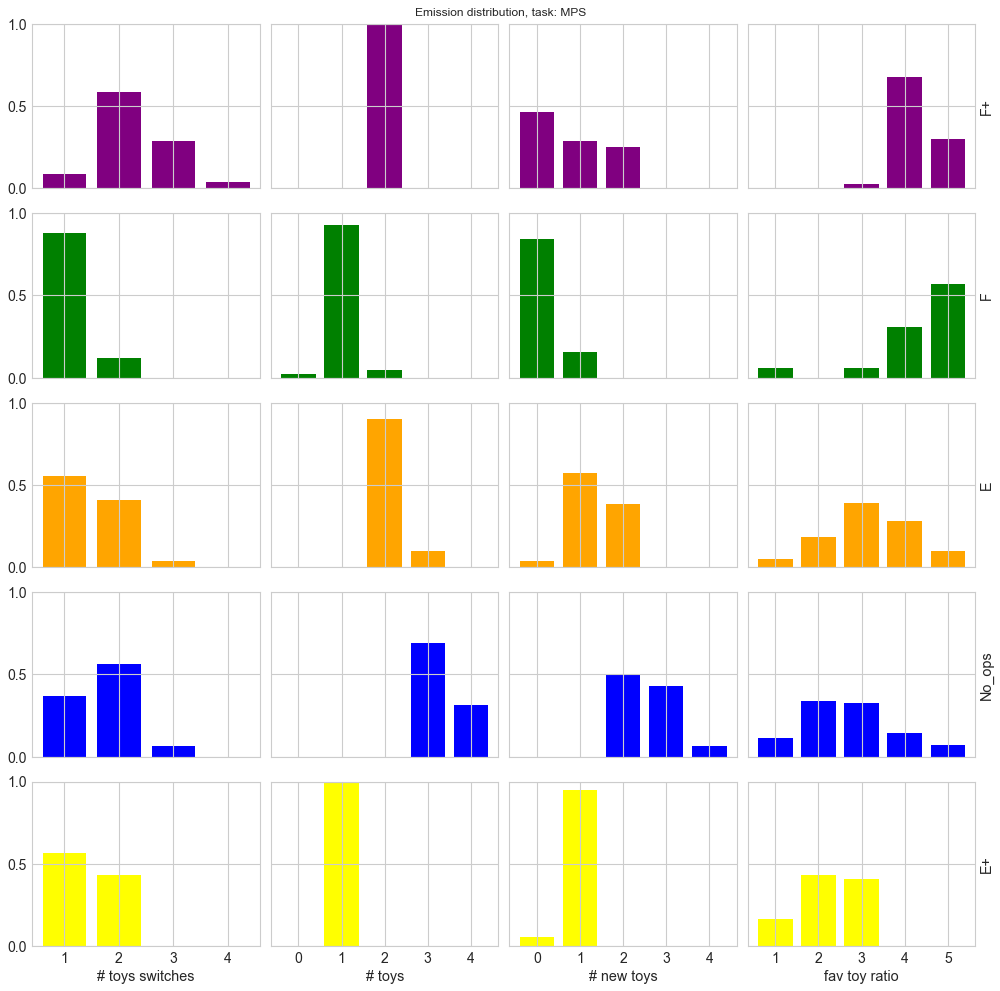

In [117]:
mps_state_name_dict = OrderedDict({2: "F+", 1: "F",  3: "E", 0:"No_ops", 4:"E+"})

draw_distribution(n_features, mps_state_name_dict, discretized_input_dict[task], np.array(flatten_pred_mps), "MPS",feature_names)

In [70]:
task = 'MPM' 
n_states_mpm = 4
list_seq_mpm = convert_to_list_seqs(discretized_input_dict[task], len_dict[task])
list_seq_mpm = convert_to_int(list_seq_mpm)
mpm_model = init_hmm(n_states_mpm, discretized_input_dict[task].T, seed)
mpm_model.bake()
mpm_model.fit(list_seq_mpm, labels = label_dict[task])

{
    "class" : "HiddenMarkovModel",
    "name" : "None",
    "start" : {
        "class" : "State",
        "distribution" : null,
        "name" : "None-start",
        "weight" : 1.0
    },
    "end" : {
        "class" : "State",
        "distribution" : null,
        "name" : "None-end",
        "weight" : 1.0
    },
    "states" : [
        {
            "class" : "State",
            "distribution" : {
                "class" : "Distribution",
                "name" : "IndependentComponentsDistribution",
                "parameters" : [
                    [
                        {
                            "class" : "Distribution",
                            "dtype" : "int",
                            "name" : "DiscreteDistribution",
                            "parameters" : [
                                {
                                    "1" : 0.10759646910041473,
                                    "2" : 0.6099654440098986,
                                    "3

In [71]:
i = 0
log_prob_list_mpm = []

if task not in input_dict.keys():
    input_dict[task] = {}

for subj, shifted_df_dict in feature_dict[task].items():
    if subj not in input_dict[task].keys():
        input_dict[task][subj] = {}


    for shift_time, feature_vector in shifted_df_dict.items():
        # print(i)
        input_dict["MPM"][subj][shift_time] = list_seq_mpm[i]
        i += 1

if task not in pred_dict.keys():
    pred_dict[task] = {}
    proba_dict[task] = {}
    all_proba_dict[task] = {}

for subj, shifted_dict in input_dict[task].items():
    if subj not in pred_dict[task].keys():
        pred_dict[task][subj] = {}
        proba_dict[task][subj] = {}
        all_proba_dict[task][subj] = {}

    for shift_time, feature_vector in shifted_dict.items():
        pred_dict[task][subj][shift_time] = mpm_model.predict(feature_vector)
        proba_dict[task][subj][shift_time] = np.amax(mpm_model.predict_proba(feature_vector), axis = 1)
        log_prob = mpm_model.log_probability(feature_vector)
        all_proba_dict[task][subj][shift_time] = mpm_model.predict_proba(feature_vector)
        

        log_prob_list_mpm.append(log_prob)
print(np.mean(log_prob_list_mpm))

-24.461610931959267


In [72]:
flatten_pred_mpm = []
if task not in flatten_pred_dict.keys():
    flatten_pred_dict[task] = []
task_specific_pred_dict = pred_dict[task]
for subj, subj_dict in task_specific_pred_dict.items():
    for shift_time, pred in subj_dict.items():
        flatten_pred_dict[task].extend(pred)
        flatten_pred_mpm.extend(pred)

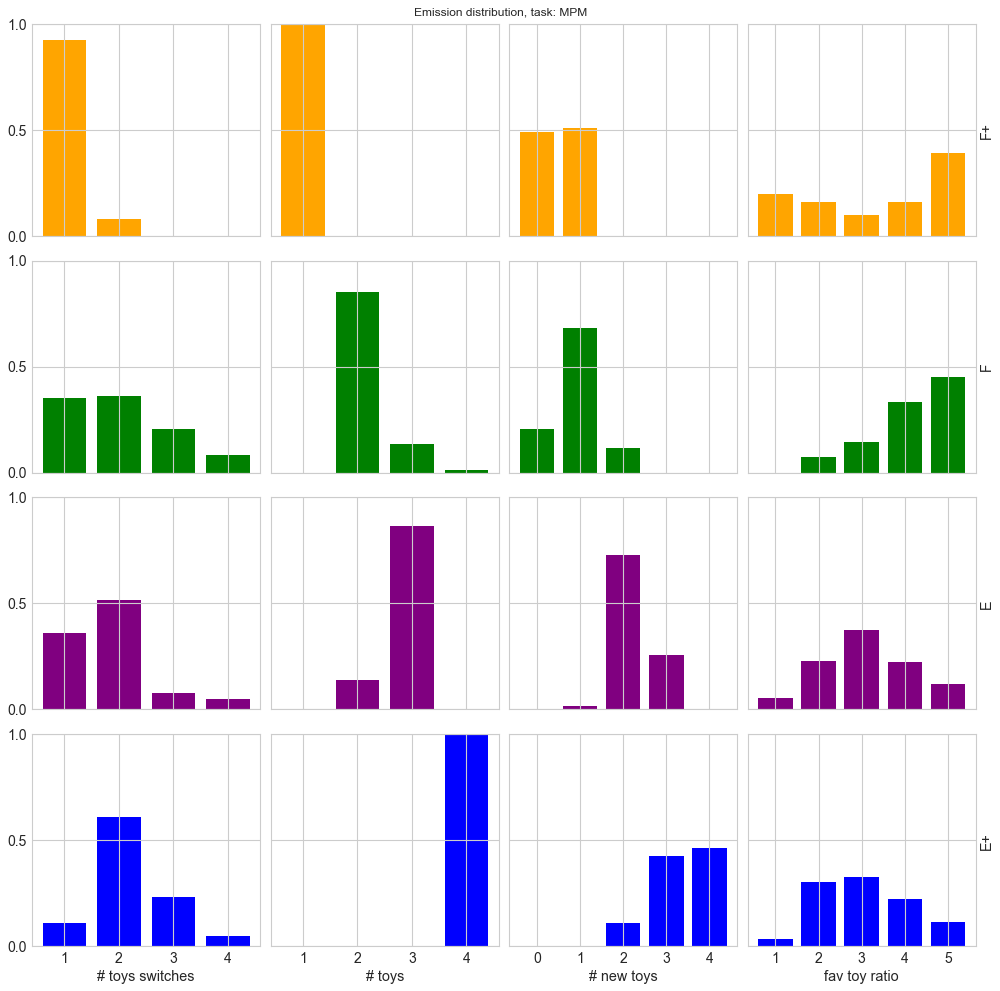

In [74]:
mpm_state_name_dict = OrderedDict({3: "F+", 1: "F",  2: "E", 0: "E+"})

draw_distribution(n_features, mpm_state_name_dict, discretized_input_dict[task], np.array(flatten_pred_mpm), "MPM",feature_names)

### Task: NMS

In [76]:
task = 'NMS' 
n_states_nms = 5
list_seq_nms = convert_to_list_seqs(discretized_input_dict[task], len_dict[task])
list_seq_nms = convert_to_int(list_seq_nms)
nms_model = init_hmm(n_states_nms, discretized_input_dict[task].T, seed)
nms_model.bake()
nms_model.fit(list_seq_nms, labels = label_dict[task])

                                    "3" : 0.0
                                }
                            ],
                            "frozen" : false
                        },
                        {
                            "class" : "Distribution",
                            "dtype" : "int",
                            "name" : "DiscreteDistribution",
                            "parameters" : [
                                {
                                    "0" : 0.9428380060578486,
                                    "1" : 0.05716199394215124,
                                    "2" : 0.0,
                                    "3" : 0.0,
                                    "4" : 0.0
                                }
                            ],
                            "frozen" : false
                        },
                        {
                            "class" : "Distribution",
                            "dtype" : "int",
                         

In [77]:
i = 0
log_prob_list_nms = []

if task not in input_dict.keys():
    input_dict[task] = {}

for subj, shifted_df_dict in feature_dict[task].items():
    if subj not in input_dict[task].keys():
        input_dict[task][subj] = {}


    for shift_time, feature_vector in shifted_df_dict.items():
        input_dict["NMS"][subj][shift_time] = list_seq_nms[i]
        i += 1

if task not in pred_dict.keys():
    pred_dict[task] = {}
    proba_dict[task] = {}
    all_proba_dict[task] = {}

for subj, shifted_dict in input_dict[task].items():
    if subj not in pred_dict[task].keys():
        pred_dict[task][subj] = {}
        proba_dict[task][subj] = {}
        all_proba_dict[task][subj] = {}

    for shift_time, feature_vector in shifted_dict.items():
        pred_dict[task][subj][shift_time] = nms_model.predict(feature_vector)
        proba_dict[task][subj][shift_time] = np.amax(nms_model.predict_proba(feature_vector), axis = 1)
        log_prob = nms_model.log_probability(feature_vector)
        all_proba_dict[task][subj][shift_time] = nms_model.predict_proba(feature_vector)
        

        log_prob_list_nms.append(log_prob)
print(np.mean(log_prob_list_nms))

-21.93807572926109


In [78]:
flatten_pred_nms = []
if task not in flatten_pred_dict.keys():
    flatten_pred_dict[task] = []
task_specific_pred_dict = pred_dict[task]
for subj, subj_dict in task_specific_pred_dict.items():
    for shift_time, pred in subj_dict.items():
        flatten_pred_dict[task].extend(pred)
        flatten_pred_nms.extend(pred)

In [100]:
print(discretized_input_dict["NMS"][np.array(flatten_pred_nms)==0])

[[1. 0. 0. 1.]
 [1. 0. 0. 1.]
 [1. 0. 0. 1.]
 [1. 0. 0. 1.]
 [1. 0. 0. 1.]
 [1. 0. 0. 1.]
 [1. 1. 0. 1.]
 [1. 0. 0. 1.]
 [1. 0. 0. 1.]
 [1. 0. 0. 1.]
 [1. 0. 0. 1.]
 [1. 0. 0. 1.]
 [1. 0. 0. 1.]
 [1. 0. 0. 1.]
 [1. 0. 0. 1.]
 [1. 0. 0. 1.]
 [1. 0. 0. 1.]
 [1. 1. 0. 1.]
 [1. 0. 0. 1.]
 [1. 0. 0. 1.]
 [1. 0. 0. 1.]
 [1. 0. 0. 1.]
 [1. 0. 0. 1.]
 [1. 0. 0. 1.]
 [1. 0. 0. 1.]
 [1. 0. 0. 1.]
 [1. 0. 0. 1.]
 [1. 1. 0. 1.]
 [1. 0. 0. 1.]
 [1. 0. 0. 1.]
 [1. 1. 0. 1.]
 [1. 0. 0. 1.]
 [1. 0. 0. 1.]
 [1. 0. 0. 1.]
 [1. 0. 0. 1.]
 [1. 0. 0. 1.]
 [1. 0. 0. 1.]
 [1. 0. 0. 1.]
 [1. 0. 0. 1.]
 [1. 0. 0. 1.]
 [1. 0. 0. 1.]
 [1. 0. 0. 1.]
 [1. 0. 0. 1.]
 [1. 0. 0. 1.]
 [1. 0. 0. 1.]
 [1. 0. 0. 1.]
 [1. 0. 0. 1.]
 [1. 0. 0. 1.]
 [1. 0. 0. 1.]
 [1. 0. 0. 1.]
 [1. 0. 0. 1.]
 [1. 0. 0. 1.]
 [1. 0. 0. 1.]
 [1. 0. 0. 1.]
 [1. 0. 0. 1.]
 [1. 0. 0. 1.]
 [1. 0. 0. 1.]
 [1. 0. 0. 1.]
 [1. 0. 0. 1.]
 [1. 0. 0. 1.]
 [1. 0. 0. 1.]
 [1. 0. 0. 1.]
 [1. 0. 0. 1.]
 [1. 0. 0. 1.]
 [1. 0. 0. 1.]
 [1. 0. 0. 1.]
 [1. 0. 0.

In [101]:
np.array(flatten_pred_nms)==0

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False,  True, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,  True, False, False, False, False,  True, False,
       False, False, False, False, False, False,  True, False, False,
       False, False,  True, False, False, False, False,  True, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False,  True,  True,
        True,  True,  True, False, False, False,  True,  True,  True,
       False, False, False, False,  True,  True, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

In [97]:
len(flatten_pred_nms)

654

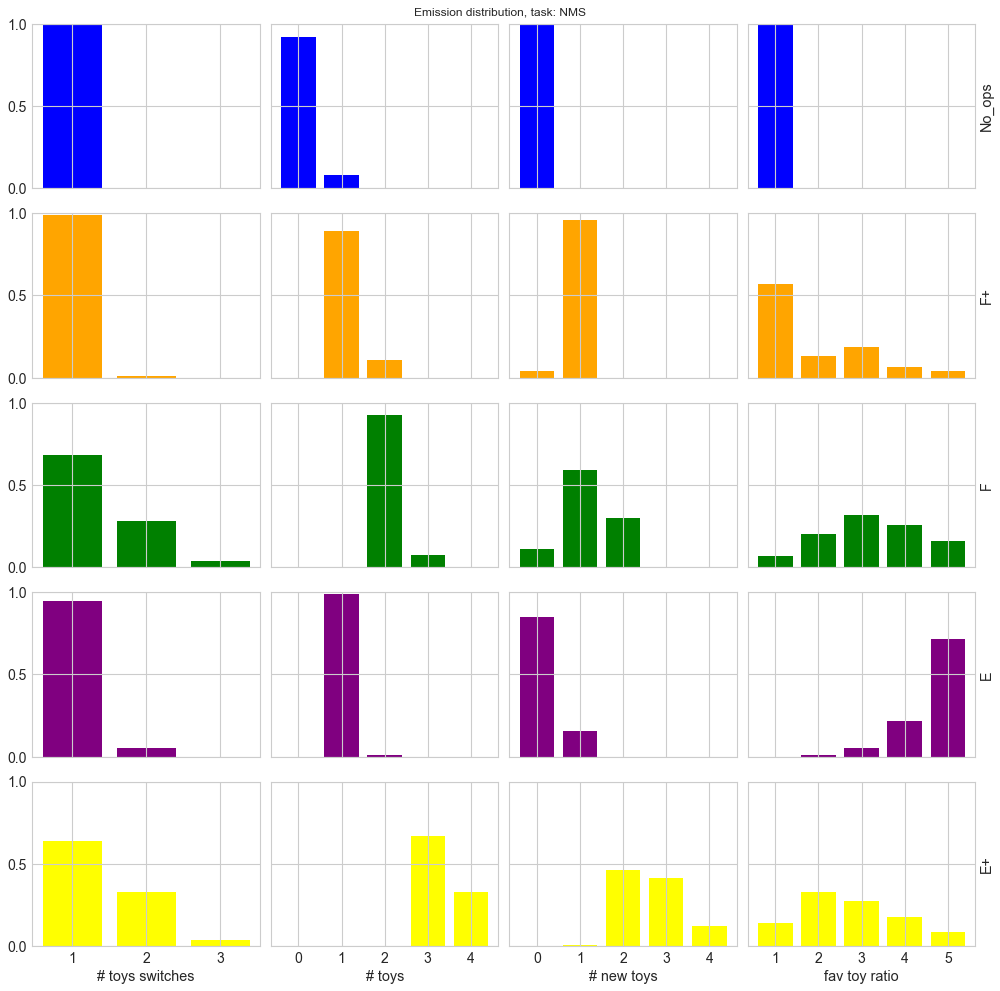

In [79]:
nms_state_name_dict = OrderedDict({0:"No_ops", 3: "F+", 1: "F",  2: "E", 4: "E+"})

draw_distribution(n_features, nms_state_name_dict, discretized_input_dict[task], np.array(flatten_pred_nms), "NMS",feature_names)

In [80]:
task = 'NMM' 
n_states_nmm = 5
list_seq_nmm = convert_to_list_seqs(discretized_input_dict[task], len_dict[task])
list_seq_nmm = convert_to_int(list_seq_nmm)
nmm_model = init_hmm(n_states_nmm, discretized_input_dict[task].T, seed)
nmm_model.bake()
nmm_model.fit(list_seq_nmm, labels = label_dict[task])

                      ],
                            "frozen" : false
                        },
                        {
                            "class" : "Distribution",
                            "dtype" : "int",
                            "name" : "DiscreteDistribution",
                            "parameters" : [
                                {
                                    "0" : 0.999999999998837,
                                    "1" : 1.1630143719821493e-12,
                                    "2" : 0.0,
                                    "3" : 0.0,
                                    "4" : 0.0
                                }
                            ],
                            "frozen" : false
                        },
                        {
                            "class" : "Distribution",
                            "dtype" : "int",
                            "name" : "DiscreteDistribution",
                            "parameters" : [
   

In [86]:
i = 0
log_prob_list_nmm = []

if task not in input_dict.keys():
    input_dict[task] = {}

for subj, shifted_df_dict in feature_dict[task].items():
    if subj not in input_dict[task].keys():
        input_dict[task][subj] = {}


    for shift_time, feature_vector in shifted_df_dict.items():
        input_dict["NMM"][subj][shift_time] = list_seq_nmm[i]
        i += 1

if task not in pred_dict.keys():
    pred_dict[task] = {}
    proba_dict[task] = {}
    all_proba_dict[task] = {}

for subj, shifted_dict in input_dict[task].items():
    if subj not in pred_dict[task].keys():
        pred_dict[task][subj] = {}
        proba_dict[task][subj] = {}
        all_proba_dict[task][subj] = {}

    for shift_time, feature_vector in shifted_dict.items():
        pred_dict[task][subj][shift_time] = nmm_model.predict(feature_vector)
        proba_dict[task][subj][shift_time] = np.amax(nmm_model.predict_proba(feature_vector), axis = 1)
        log_prob = nmm_model.log_probability(feature_vector)
        all_proba_dict[task][subj][shift_time] = nmm_model.predict_proba(feature_vector)
        

        log_prob_list_nmm.append(log_prob)
print(np.mean(log_prob_list_nmm))

-22.94795578420061


In [87]:
flatten_pred_nmm = []
if task not in flatten_pred_dict.keys():
    flatten_pred_dict[task] = []
task_specific_pred_dict = pred_dict[task]
for subj, subj_dict in task_specific_pred_dict.items():
    for shift_time, pred in subj_dict.items():
        flatten_pred_dict[task].extend(pred)
        flatten_pred_nmm.extend(pred)

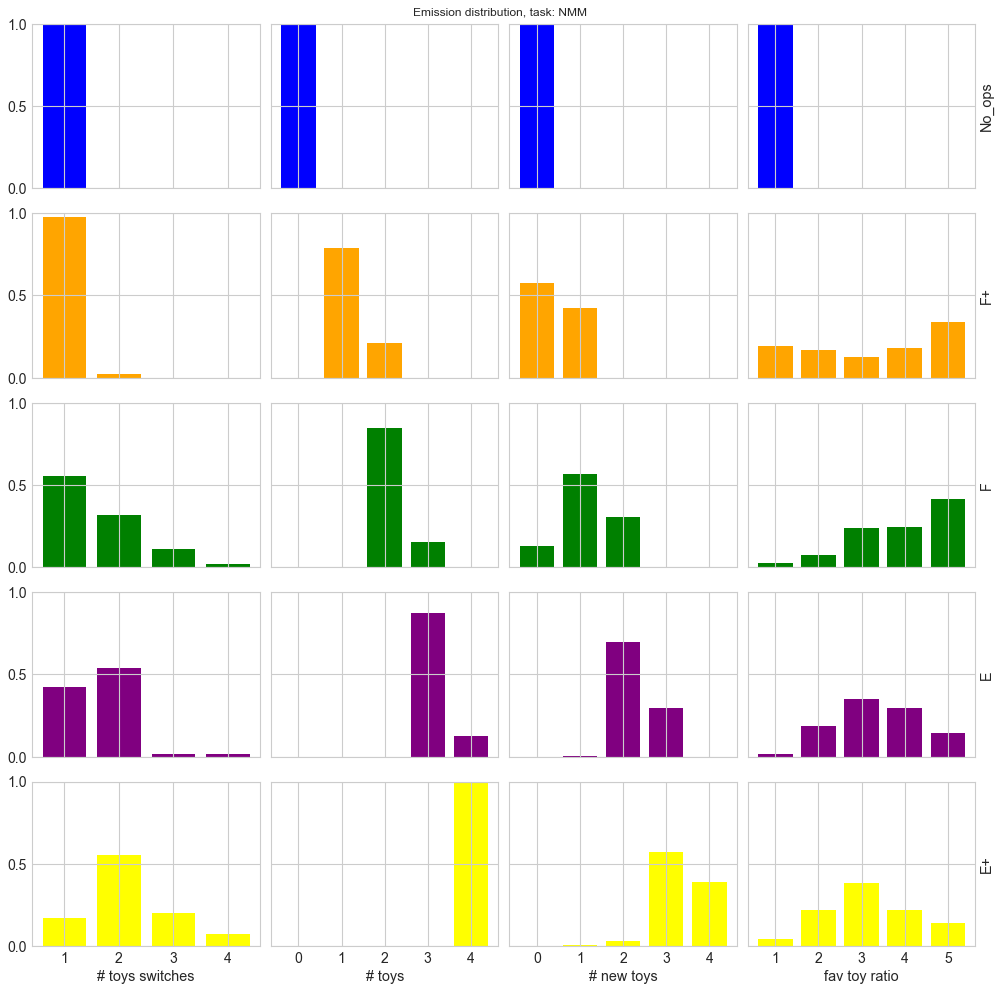

In [88]:
nmm_state_name_dict = OrderedDict({0:"No_ops", 3: "F+", 1: "F",  2: "E", 4: "E+"})

draw_distribution(n_features, nmm_state_name_dict, discretized_input_dict[task], np.array(flatten_pred_nmm), "NMM",feature_names)